In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import argparse
import torch.utils.data
from torchvision import datasets
from torch.utils.data import DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5068,0.4861,0.4403), (0.2684, 0.2563, 0.2759)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5068,0.4861,0.4403), (0.2684, 0.2563, 0.2759)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data10', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='./data10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [5]:
atmtrain = []
for img,idx in trainset:
    if idx == 1:
        atmtrain.append(img)
    

In [6]:
atmtest = []
for img,idx in testset:
    if idx == 1:
        atmtest.append(img)

In [7]:
trainloader = torch.utils.data.DataLoader(
    atmtrain, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    atmtrain, batch_size=256, shuffle=False, num_workers=2)

In [8]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self, hiddens=[16, 32, 64, 128, 256], latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        modules = []
        prev_channels = 3
        img_length = 32
        for cur_channels in hiddens:
            modules.append(nn.Sequential(
                nn.Conv2d(prev_channels, cur_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(cur_channels),
                nn.ReLU()))
            prev_channels = cur_channels
            img_length //= 2
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(prev_channels * img_length * img_length, latent_dim)
        self.fc_logvar = nn.Linear(prev_channels * img_length * img_length, latent_dim)

        # Decoder layers
        modules = []
        self.decoder_input = nn.Linear(latent_dim, prev_channels * img_length * img_length)
        self.decoder_input_chw = (prev_channels, img_length, img_length)
        for i in range(len(hiddens) - 1, 0, -1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(hiddens[i], hiddens[i-1], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(hiddens[i-1]),
                nn.ReLU()))
        modules.append(nn.Sequential(
            nn.ConvTranspose2d(hiddens[0],  hiddens[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hiddens[0]), nn.ReLU(),
            nn.Conv2d(hiddens[0], 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()))  # You might want to change this to a sigmoid if your inputs are normalized to [0, 1]
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        eps = torch.randn_like(logvar)
        std = torch.exp(logvar / 2)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = torch.reshape(z, (-1, *self.decoder_input_chw))
        decoded = self.decoder(z)
        return decoded

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantiate and use the VAE
model = VAE()


In [9]:
def train(epoch):


    #begin_time = time()
    # train
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        #data = torch.flatten(data, start_dim=1)
        #data = data.to(device)
        data = Variable(data)
        #data = data.cuda()

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item()/ len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))

In [10]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data in testloader:
        #data = torch.flatten(data, start_dim=1)
        
        #data = data.cuda()
        data = Variable(data)
        #data = data.cuda()

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
kl_weight = 0.00025
lr = 0.005

def loss_function( recon_x, x, mu, logvar):
    recons_loss = F.mse_loss(recon_x, x)
    kl_divergence = torch.mean(
         -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mu**2, 1), 0)
    loss = recons_loss + kl_divergence * kl_weight
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr)


In [29]:
for epoch in range(10):
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/5000 (0%)]	Loss: 0.000311
Train Epoch: 0 [1280/5000 (25%)]	Loss: 0.000295
Train Epoch: 0 [2560/5000 (50%)]	Loss: 0.000285
Train Epoch: 0 [3840/5000 (75%)]	Loss: 0.000296
====> Epoch: 0 Average loss: 0.0003
====> Test set loss: 0.0001
Train Epoch: 1 [0/5000 (0%)]	Loss: 0.000292
Train Epoch: 1 [1280/5000 (25%)]	Loss: 0.000295
Train Epoch: 1 [2560/5000 (50%)]	Loss: 0.000298
Train Epoch: 1 [3840/5000 (75%)]	Loss: 0.000296
====> Epoch: 1 Average loss: 0.0003
====> Test set loss: 0.0001
Train Epoch: 2 [0/5000 (0%)]	Loss: 0.000305
Train Epoch: 2 [1280/5000 (25%)]	Loss: 0.000310
Train Epoch: 2 [2560/5000 (50%)]	Loss: 0.000309
Train Epoch: 2 [3840/5000 (75%)]	Loss: 0.000288
====> Epoch: 2 Average loss: 0.0003
====> Test set loss: 0.0001
Train Epoch: 3 [0/5000 (0%)]	Loss: 0.000282
Train Epoch: 3 [1280/5000 (25%)]	Loss: 0.000281
Train Epoch: 3 [2560/5000 (50%)]	Loss: 0.000306
Train Epoch: 3 [3840/5000 (75%)]	Loss: 0.000311
====> Epoch: 3 Average loss: 0.0003
====> Test set loss:

KeyboardInterrupt: 

In [30]:
import matplotlib.pyplot as plt
import numpy as np

torch.Size([32, 32, 3])


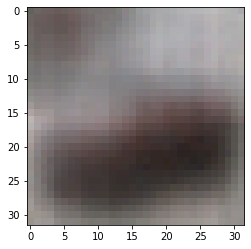

In [40]:
data = torch.randn(1,128)

y=model.decode(data)
y=y.squeeze()
img=y.swapaxes(0,1)
img=img.swapaxes(1,2)
#img=img.swapaxes(2,3)
img = img.cpu().detach()
print(img.shape)
img = img.numpy()
plt.imshow(img,cmap ='viridis')
#plt.colorbar()
plt.show()